# <center>CSE 4/574: Introduction to Machine Learning</center>
## <center>Prof. Sargur Srihari</center>
### <center>Assignment 3</center>

In [1]:
# Imports
import gym
from gym import spaces
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Stock Trading Environment 

In [2]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gym.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing whether the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path  # Path of the CSV file containing the historical stock data.
        self.stock_data = pd.read_csv(self.file_path)  # Reading the CSV file containing the historical stock data.
        self.train = train  # Boolean indicating to use the training stock data by default.
        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()
        self.observation_space = spaces.Discrete(4)  # This defines that there are four states in the environment.
        
        # This defines that there are 3 discrete actions that the agent can perform (Buy, Sell, Hold).
        self.action_space = spaces.Discrete(3)
        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()
        


    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - (Integer in the range of 0 to 3 representing the four possible observations that the
                                 agent can receive. The observation depends upon whether the price increased on average
                                 in the number of days the agent considers, and whether the agent already has the stock
                                 or not.)"""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector that will be passed to the agent.
            observation = [price_increase, price_decrease, 0, 1]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector.
            observation = [price_increase, price_decrease, 0, 1]
        if np.array_equal(observation, [1, 0, 0, 1]):
            observation = 0
        if np.array_equal(observation, [1, 0, 1, 0]):
            observation = 1
        if np.array_equal(observation, [0, 1, 0, 1]):
            observation = 2
        if np.array_equal(observation, [0, 1, 1, 0]):
            observation = 3

        return observation

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - (Integer in the range 0 to 2 inclusive.)

        :returns observation: - (Integer in the range of 0 to 3 representing the four possible observations that the
                                 agent can receive. The observation depends upon whether the price increased on average
                                 in the number of days the agent considers, and whether the agent already has the stock
                                 or not.)
                 reward: - (Integer/Float value that's used to measure the performance of the agent.)
                 done: - (Boolean describing whether or not the episode has ended.)
                 info: - (A dictionary that can be used to provide additional implementation information.)"""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = 1
            stock_not_held = 0
        else:
            stock_held = 0
            stock_not_held = 1

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector.
            observation = [price_increase, price_decrease, stock_held, stock_not_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector.
            observation = [price_increase, price_decrease, stock_held, stock_not_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [1, 0, 0, 1]):
            observation = 0
        if np.array_equal(observation, [1, 0, 1, 0]):
            observation = 1
        if np.array_equal(observation, [0, 1, 0, 1]):
            observation = 2
        if np.array_equal(observation, [0, 1, 1, 0]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the number of infected people becomes greater than 75 % of the population.
        done = True if (self.timestep >= self.max_timesteps) \
            else False

        info = {}
        return observation, reward, done, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

### TO DO: Implement the Q-learning algorithm 

In [3]:
# Implementing Q-Learning for the stock trading environment.
class QLearning:
    """This class implements the Q-learning algorithm."""

    def __init__(self, environment):
        """This method instantiates the Q-learning parameters.

        :param environment: - This is the environment which needs to be solved."""

        self.environment = environment
        
        """TO DO: Instantiate the Q-learning parameters."""
        
        #Initializing the Q-Table with 4 states and 3 actions.
        self.r,self.c=4,3
        self.Q=np.zeros(shape=(self.r,self.c))
        
        #No of epochs.
        self.epoch=1000
        
        #Instantiating other parameters utilized while updating the Q-Table
        self.discount_factor=0.9
        self.epsilon = 1
        self.decay_epsilon = 0.999
        self.learning_rate = 0.9 
        
        #Rewards and Epsilon lists are defined to store the updated value of reward and epsilon at each episode.
        self.Rewards_List=np.zeros(shape=(self.epoch)).astype(int)
        self.Epsilon_List=[]
        

        

        
    def train(self):
        """This method performs the agent training."""

        """TO DO: Implement the Q-learning algorithm and train the agent."""
        
        #Epsilon value updated at each episode is stored in below variable.
        Epsilon_per_Episode = self.epsilon
        
        #Running the loop for the set number of epochs.
        for i in range(self.epoch):
            
            #All the necessary values are set to default at the beginning of each episode.
            obs=self.environment.reset()
            #new_done variable is set to False initially so that we do not start at the destination state.
            new_done=False
            
            
            #Epsilon value is calculated at each episode.
            Epsilon_per_Episode = Epsilon_per_Episode*self.decay_epsilon
            self.Epsilon_List.append(Epsilon_per_Episode)
            Rewards_per_Episode = 0
            
            #Continue updating the loop till we reach the destination state.
            while not new_done:
                
                #We determine the next action to be taken at the current state.
                #We randomly select either any action or the action that yields best Q-value.
                action_index = self.next_action_index(Epsilon_per_Episode, obs)
                
                #calling the step() which performs the ncessary steps and returns the new state, reward etc.
                new_obs, new_rew, new_done, new_info=self.environment.step(action_index)
                
                #Calculating the best Q-value in the next state which we obtained in previous step.
                max_next_state = np.max(self.Q[new_obs])
                
                #Estimating the Q-value for the current state.
                self.Q[obs][action_index]= self.Q[obs][action_index]+ self.learning_rate*(new_rew + (self.discount_factor*max_next_state) - self.Q[obs][action_index])
                obs=new_obs 
                
                #reward value for the current episode is stored here.
                Rewards_per_Episode+=new_rew
                
            #The total reward value for one single episode is stored here.    
            self.Rewards_List[i] = Rewards_per_Episode
        
            

    def evaluate(self):
        """This method evaluate the trained agent's performance."""

        """"TO DO: Evaluate the trained agent's performance by selecting only the greedy/best action in each state."""
        self.environment.train = False
        
        #We reset the necessary values again to default before verifying the performance on Test data set.
        obs=self.environment.reset()
        new_done=False
        
        #Continue updating the loop till we reach the destination state.
        #Note that here we onl select the action that yields max Q-value.
        while not new_done:
            action_index = np.argmax(self.Q[obs])
            new_obs, new_rew, new_done, new_info=self.environment.step(action_index)
            obs=new_obs  
            
        
          

    def plot(self,):
        """This method plots the reward dynamics and epsilon decay."""

        """TO DO: Plot the total reward per episode and epsilon decay when training."""
        
        #The below function plots the graph on Total Account Value over Time. 
        self.environment.render()
        print("\nThe total account value obtained is: ", self.environment.total_account_value)
        
        print("\n\n")
        #The below function plots the graph on Rewards over Episodes.
        self.plot_reward_per_episode()
        
        print("\n\n")
        #The below function plots the graph on Epsilon values over Episodes.
        self.plot_epsilon_per_episode()
        
        

    
    def next_action_index(self, epsilon, obs):
        
        #if the randomly value chosen between 0 and 1 is less than the current epsilon, then choose a random action.
        if np.random.uniform(0, 1) < epsilon:
            return self.environment.action_space.sample() 
        
        else: #Else choose the index with max Q-value for the current state.
            return np.argmax(self.Q[obs])
        
        
        
        
    def plot_reward_per_episode(self):

        plt.figure(figsize=(15, 10))
        plt.scatter(list(range(self.epoch)), self.Rewards_List, color='red')
        plt.xlabel('Episodes', fontsize=25)
        plt.ylabel('Reward Value', fontsize=25)
        plt.title('Rewards Per Episode (During Learning)', fontsize=30)
        plt.grid()
        plt.show()
        
        
    def plot_epsilon_per_episode(self):
        plt.figure(figsize=(15, 10))
        plt.plot(self.Epsilon_List, color='red', linewidth=7)
        plt.xlabel('Episodes', fontsize=25)
        plt.ylabel('Epsilon values', fontsize=25)
        plt.title('Epsilon Decay', fontsize=30)
        plt.grid()
        plt.show()

        


In [4]:
stock_trading_environment = StockTradingEnvironment('./NVDA.csv', number_of_days_to_consider=10)

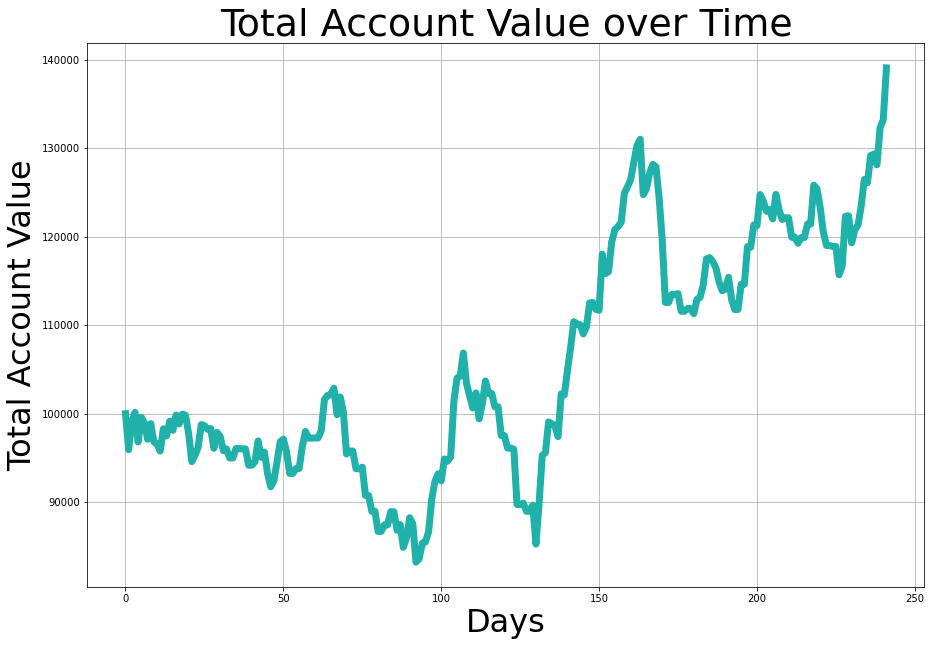


The total account value obtained is:  139095.30966699996





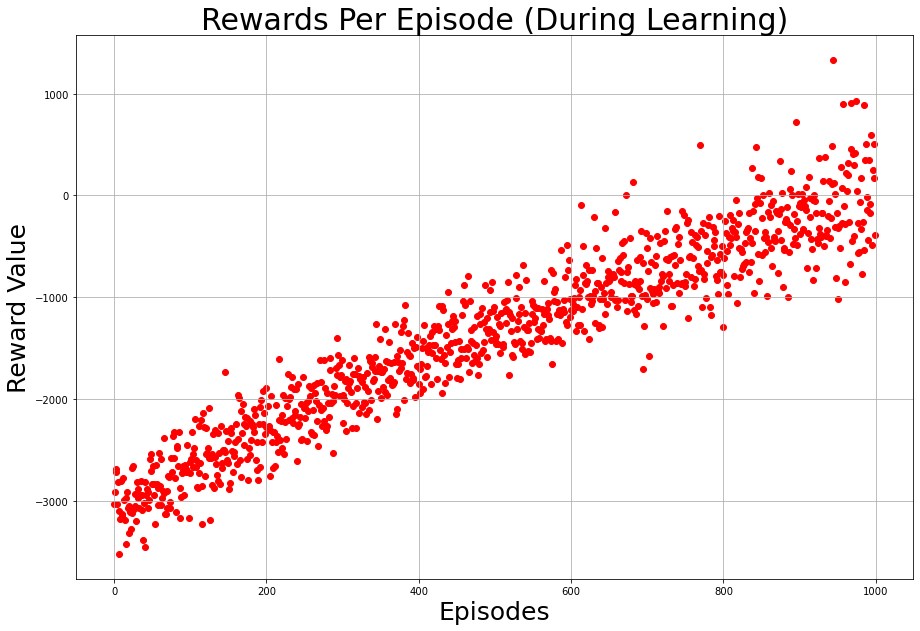

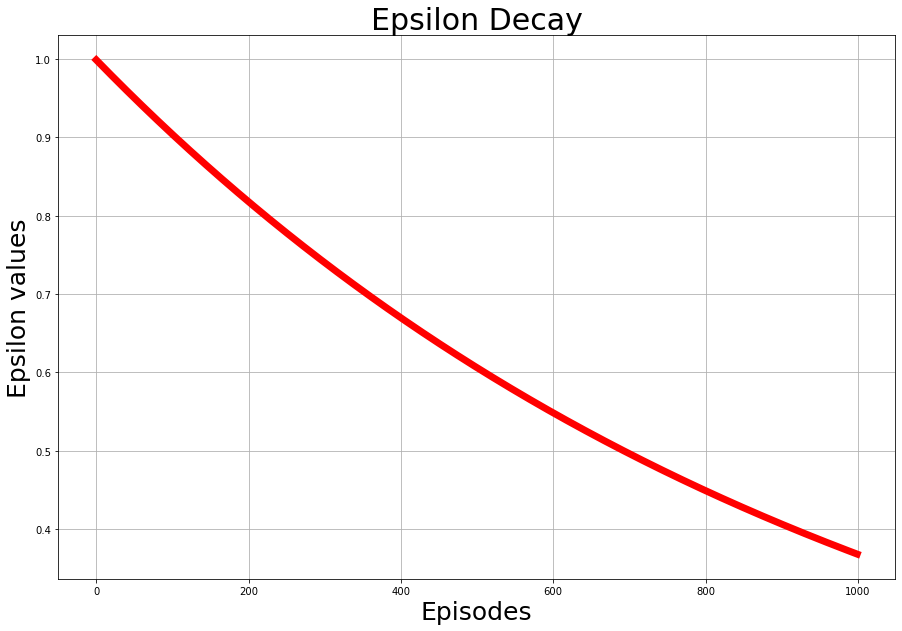

In [5]:
ql=QLearning(stock_trading_environment)
ql.train()
ql.evaluate()
ql.plot()